In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Zad.1

In [2]:
def random_population(chromosome_length, mi, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        res[num_of_child, 0, :]=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [3]:
def parent_selection(P, evaluation_result, lambda_param):
    indices=np.random.choice(len(evaluation_result), lambda_param)
    return P[indices]

In [4]:
def mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
    return P_children

In [5]:
def replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=True, looking_for_max=False):
    if not is_mi_plus_lambda:
        indices=np.argsort(-children_evaluation_result)[:mi_param] if looking_for_max else np.argsort(children_evaluation_result)[:mi_param]
        return  P_children[indices], children_evaluation_result[indices]
    else:
        all_evaluation_results=np.concatenate((evaluation_result, children_evaluation_result))
        full_population=np.concatenate((P, P_children))
        indices=np.argsort(-all_evaluation_results)[:mi_param] if looking_for_max else np.argsort(all_evaluation_results)[:mi_param]
        return full_population[indices], all_evaluation_results[indices]

In [6]:
def eval_population(objective_function, population):
    population_size=len(population)
    results=np.zeros(population_size)
    for i in range(population_size):
        results[i] = objective_function(population[i])
    return results

In [7]:
def ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=random_population(chromosome_length, mi_param, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(i, P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
        min=evaluation_result.min()
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

In [8]:
def plot_chart(P):
    plt.figure(figsize=(20, 7))
    plt.plot(P[1], label="Max results")
    plt.plot(P[2], label="Mean results")
    plt.plot(P[3], label="Min results")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

## Benchmarks:

Sphere

In [9]:
def sphere(individual):
    return np.sum(individual * individual)
print(sphere(np.array([1.0, 2.0, 3.0])))

14.0


Mi + lambda

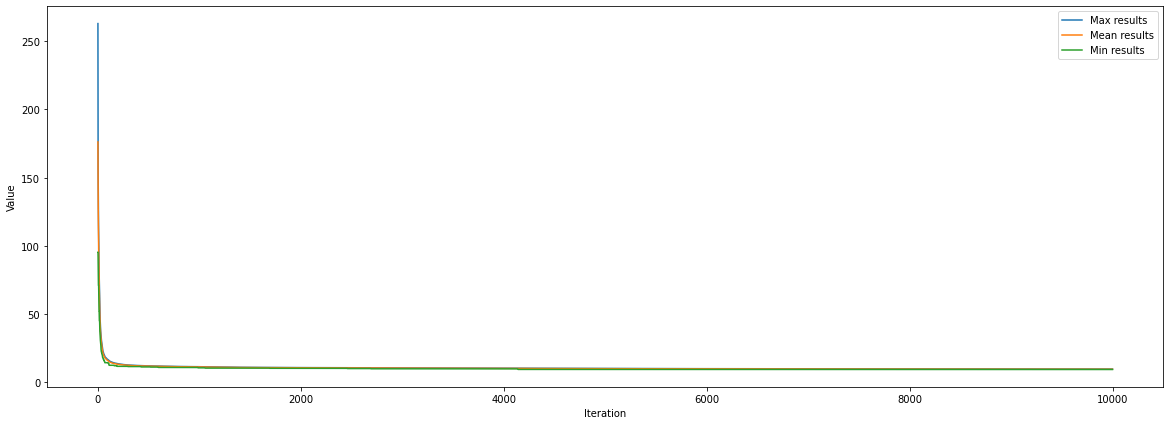

[ 0.29451388  0.05475472  0.02678067  0.08368238 -0.09645197  0.03859581
 -2.89561393  0.12578248 -0.23524158  0.10748349  0.14693229 -0.03621316
  0.27647293 -0.11954795 -0.30703785  0.08550103  0.17535154  0.14681397
  0.59870413 -0.10742082]


In [51]:
res=ES_mi_lambda(sphere, 20, 100, 100, (-5.12, 5.12))
plot_chart(res)
print(res[0])

Mi, lambda

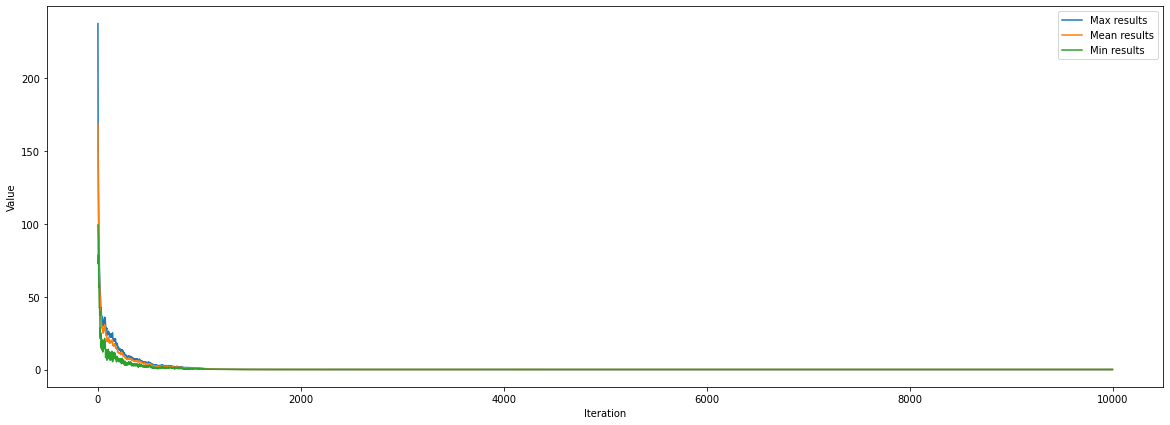

[-4.34925007e-10  2.02322134e-10  2.05286012e-10  8.11866048e-10
  1.03165517e-09  6.05707577e-11  7.87330923e-11  4.96461572e-10
  3.31915344e-10 -5.55984809e-10 -8.34794503e-11  2.20467125e-10
  8.60567770e-12  8.96056780e-11 -2.04817731e-10 -1.44392294e-10
  9.36368807e-10  2.56419439e-10  8.40289505e-11  4.28459587e-10]


In [160]:
res=ES_mi_lambda(sphere, 20, 100, 200, (-5.12, 5.12), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Sum squares

In [29]:
def sum_squares(individual):
    return np.sum(np.arange(1, len(individual) + 1) * individual * individual)
print(sum_squares(np.array([1.0, 2.0, 3.0])))

36.0


Mi + lambda

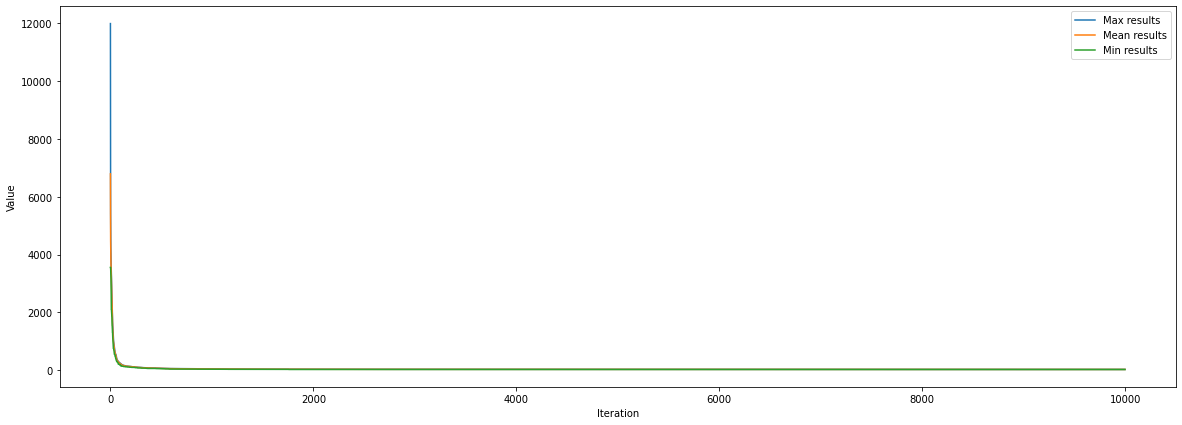

[-0.77407742  0.11512605 -0.10151288  0.22343331  0.42896061 -0.09568577
 -0.51304067  0.05292461  1.37646675  0.00410114  0.06299962 -0.21162327
 -0.1498966   0.04042094 -0.06969094 -0.11502102  0.10510768  0.10096203
  0.09679349 -0.09119291]


In [54]:
res=ES_mi_lambda(sum_squares, 20, 100, 100, (-10, 10))
plot_chart(res)
print(res[0])

Mi, lambda

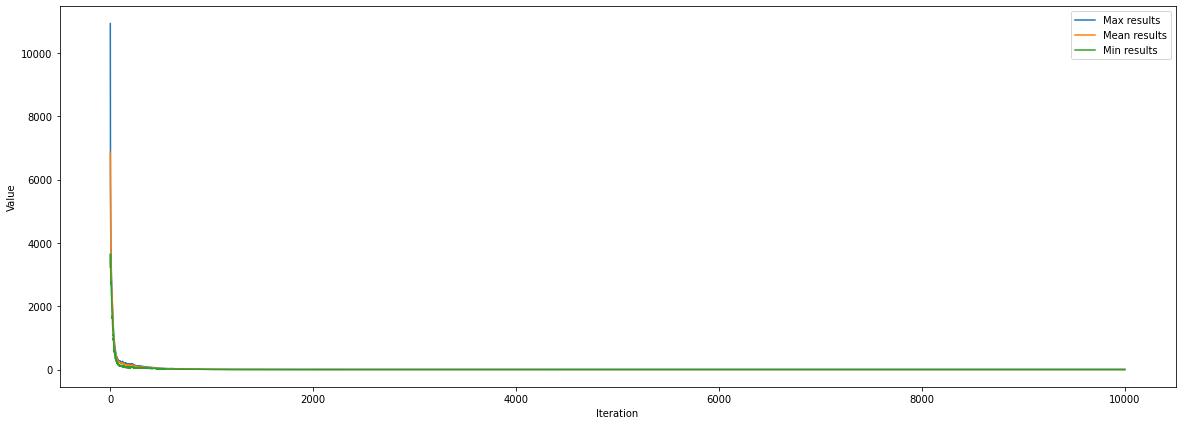

[-5.31853986e-10  3.31095261e-10 -2.58091585e-10  1.25336786e-10
  7.63758532e-10 -5.00456385e-10  3.75823135e-10 -1.09078889e-11
 -8.84093926e-11  1.08206123e-10  2.26992889e-10  3.54285232e-10
 -1.84256760e-10  5.00726711e-11  2.32583034e-13 -9.84789427e-12
  2.12764458e-10  1.65845275e-10  2.25470211e-10  1.41756068e-10]


In [161]:
res=ES_mi_lambda(sum_squares, 20, 100, 200, (-10, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Griewank

In [119]:
def griewank(individual):
    return (np.sum(individual*individual) / 4000) - np.prod(np.cos(individual / np.sqrt(np.arange(1, len(individual) + 1)))) + 1

Mi + lambda

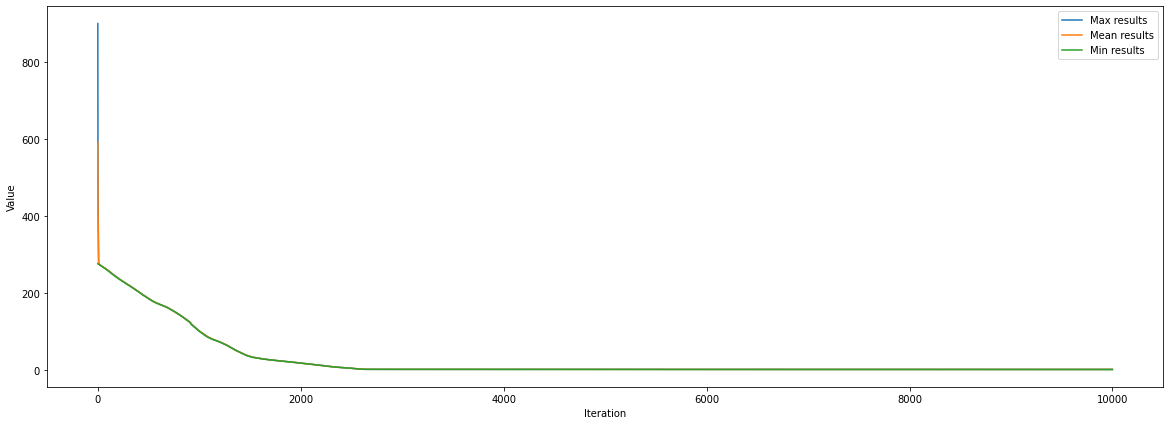

[ 12.7274802   -0.06725847 -11.20979409  -0.89774603  -0.88756555
   0.52812938   1.01729117   0.09384536  -1.49849342  -0.84996099
  -0.09209826  -0.89355176  -0.92822066  -1.18428033   0.47583957
   0.29380782   1.16783511   0.56343397  -1.44848701  -1.46715974]


In [120]:
res=ES_mi_lambda(griewank, 20, 100, 100, (-600, 600))
plot_chart(res)
print(res[0])

Mi, lambda

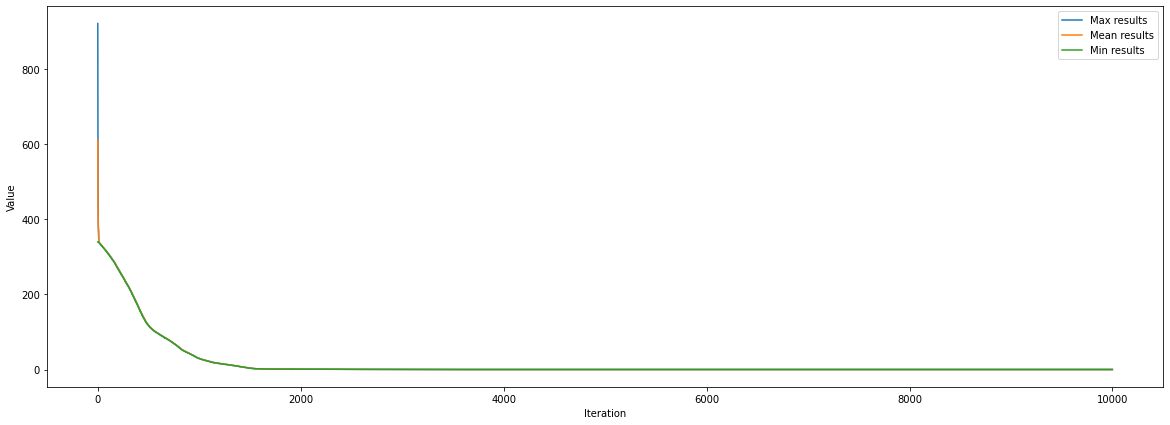

[-8.63066844e-09 -1.25041737e-08  2.51282187e-08 -3.18900786e-08
 -3.10168316e-10  6.24733417e-09 -1.15636465e-09  8.12848112e-09
  3.10827661e-08  4.05752354e-09  3.07383903e-08  5.50952918e-08
  1.63732661e-08  2.19519560e-09 -5.41421682e-10  4.73124625e-09
 -1.93960821e-08 -2.90236669e-08 -1.05074757e-08  3.20185245e-08]


In [162]:
res=ES_mi_lambda(griewank, 20, 100, 200, (-600, 600), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Rastrigin

In [11]:
def rastrigin(individual):
    return 10 * len(individual) + np.sum(individual * individual - 10 * np.cos(2 * np.pi * individual))
print(rastrigin(np.array([1.0, 4.0, 5.0])))

42.0


Mi + lambda

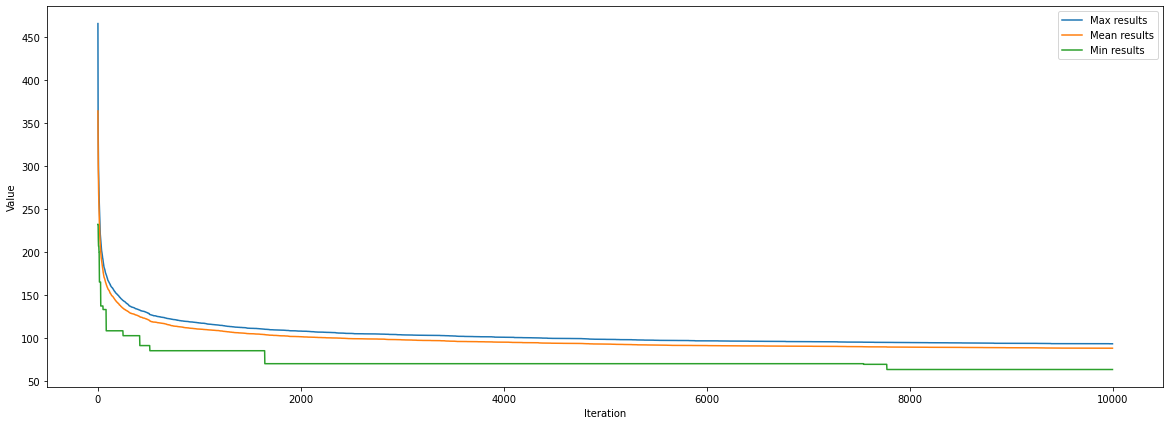

[-1.14371104e+00  1.11716969e+00  2.00656473e+00  1.46105750e-03
 -8.00650206e-02  4.54947600e-02 -7.21134776e-02 -4.99131779e-02
 -5.87032878e-02  4.02346197e+00 -1.54234119e-01 -1.25651949e-01
  1.05076105e+00  3.37765997e-02  2.05737547e+00 -9.11178855e-01
  5.71689869e-02 -3.06409013e+00 -1.09470518e+00 -3.06165837e-02]


In [166]:
res=ES_mi_lambda(rastrigin, 20, 200, 200, (-5.12, 5.12))
plot_chart(res)
print(res[0])

Rosenbrock

In [13]:
def rosenbrock(individual):
    return np.sum(100 * (individual[:len(individual) -1] ** 2 - individual[1:]) ** 2 + (1 - individual[:len(individual) -1]) ** 2)
rosenbrock(np.array([0.0, 0.0, 0.0]))

2.0

Mi + lambda

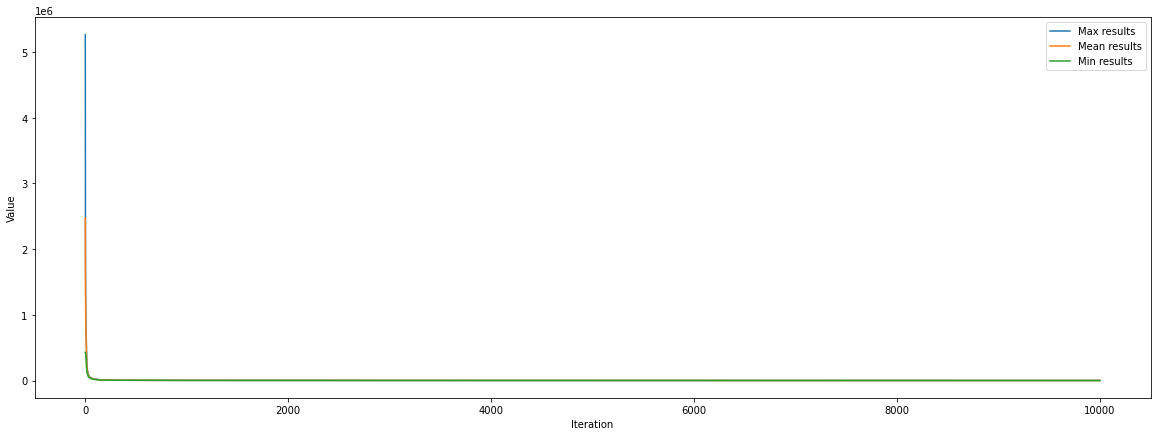

[-0.02080154 -0.07790613  0.20723324  0.05932986  0.20072413  0.13463547
  0.10800556 -0.01313519  0.16166213 -0.09823817  0.30142652  0.26407277
 -0.08797015 -0.31218763  0.34594964  0.15075215 -0.13843686 -1.18190154
  1.38584536  1.86322318]


In [168]:
res=ES_mi_lambda(rosenbrock, 20, 100, 100, (-5, 10))
plot_chart(res)
print(res[0])

## Zad.2

In [9]:
def constrained_random_population(chromosome_length, mi, restrictions, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        while(not restrictions(candidate)):
            candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [10]:
def constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if(not restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > x_bounds[1]) \
            or np.any(P_children[i, 0, :] < x_bounds[0])):
            P_children[i, 0, :] = tmp
    return P_children

In [11]:
def constrained_ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, restrictions, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population(chromosome_length, mi_param, restrictions, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 2000 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

G3

In [12]:
def G3_objective_function(individual):
    n=len(individual)
    return np.sqrt(n) ** n * np.prod(individual)

In [13]:
def constrained_random_population_for_g3(chromosome_len, mi, s_bounds):
    res=np.full((mi, 2, chromosome_len), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(0, 1, chromosome_len)
        #print(candidate)
        res[num_of_child, 0, :]=candidate / np.sqrt(np.sum(candidate ** 2))
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], )
    return res
#constrained_random_population_for_g3(10, 10, (0, 1))

In [14]:
def constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        P_children[i, 0, :] = P_children[i, 0, :] / np.sqrt(np.sum(P_children[i, 0, :] ** 2))
    return P_children

In [15]:
def constrained_ES_mi_lambda_for_g3(chromosome_length, mi_param, lambda_param, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=True):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g3(chromosome_length, mi_param, s_bounds)
    evaluation_result=eval_population(G3_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 2000 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G3_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


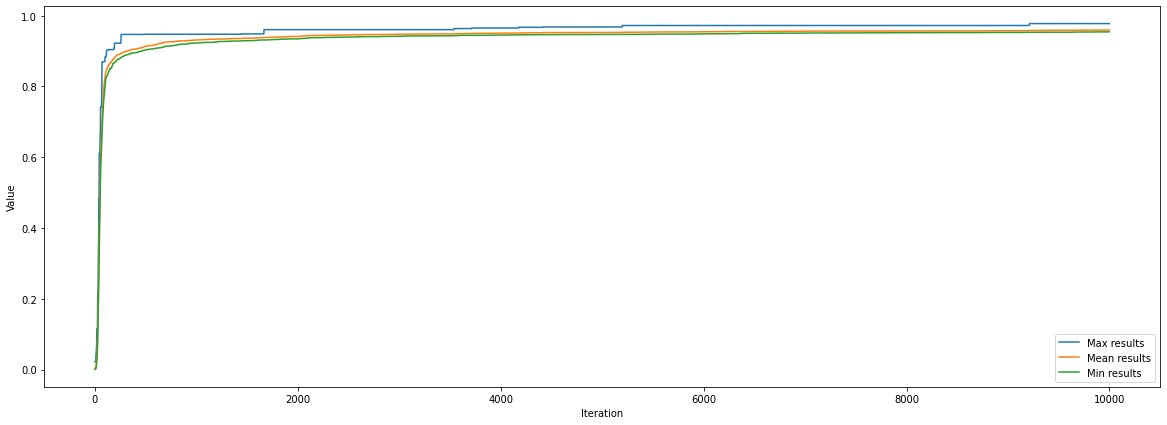

[0.23086229 0.2092501  0.21961375 0.2193427  0.2281722  0.24429702
 0.22272458 0.2268753  0.22774606 0.21901978 0.21883646 0.22568173
 0.22547556 0.23507135 0.21766125 0.21350412 0.22503255 0.22001285
 0.22206918 0.21834735]


In [76]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 50, (0, 1))
plot_chart(res)
print(res[0])

Mi, lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


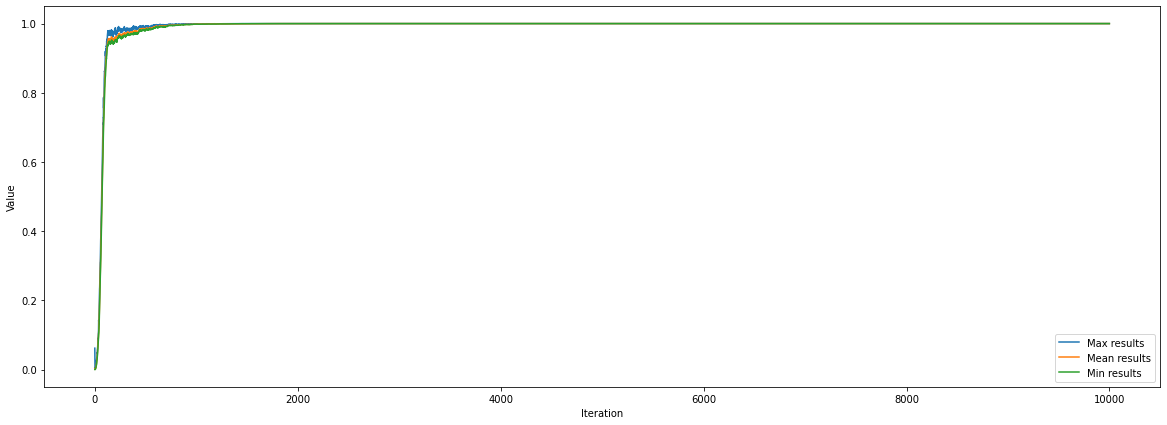

[0.2236068  0.2236068  0.2236068  0.2236068  0.2236068  0.2236068
 0.2236068  0.2236068  0.22360679 0.2236068  0.2236068  0.2236068
 0.2236068  0.2236068  0.2236068  0.2236068  0.2236068  0.2236068
 0.2236068  0.22360679]


In [16]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 100, (0, 1), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G6

In [17]:
def G6_restrictions(individual):
    return (individual[0] - 5) ** 2 +  (individual[1] - 5) ** 2 >= 100 and (individual[0] - 6) ** 2 +  (individual[1] - 5) ** 2 <= 82.81  

In [18]:
def G6_objective_function(individual):
    return (individual[0] - 10) ** 3 + (individual[1] - 20) ** 3

In [19]:
def constrained_random_population_for_g6(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        while(not G6_restrictions(candidate)):
            candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res
constrained_random_population_for_g6(10, (0, 1))

array([[[15.00441345,  5.9366319 ],
        [ 0.74753668,  0.28214614]],

       [[14.95413607,  6.18438248],
        [ 0.81991562,  0.32178006]],

       [[14.77635791,  7.10394024],
        [ 0.52668148,  0.94008622]],

       [[15.00414931,  4.33535239],
        [ 0.7816437 ,  0.04053142]],

       [[15.07195281,  5.0943395 ],
        [ 0.09259796,  0.81669094]],

       [[15.00819658,  5.23667506],
        [ 0.28512372,  0.69810569]],

       [[14.60008157,  2.19121431],
        [ 0.40034712,  0.80173026]],

       [[14.86385383,  6.98499334],
        [ 0.53170365,  0.02778661]],

       [[14.91640199,  6.78077919],
        [ 0.24780765,  0.66421717]],

       [[14.40051858,  8.46549533],
        [ 0.92346882,  0.05062712]]])

In [20]:
def constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if not restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > 100) \
            or P_children[i, 0, 0] < 13 or P_children[i, 0, 1] < 0:
            P_children[i, 0, :] = tmp
    return P_children

In [21]:
def constrained_ES_mi_lambda_for_g6(objective_function, mi_param, lambda_param, restrictions, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g6(mi_param, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 2000 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param, 2, restrictions)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


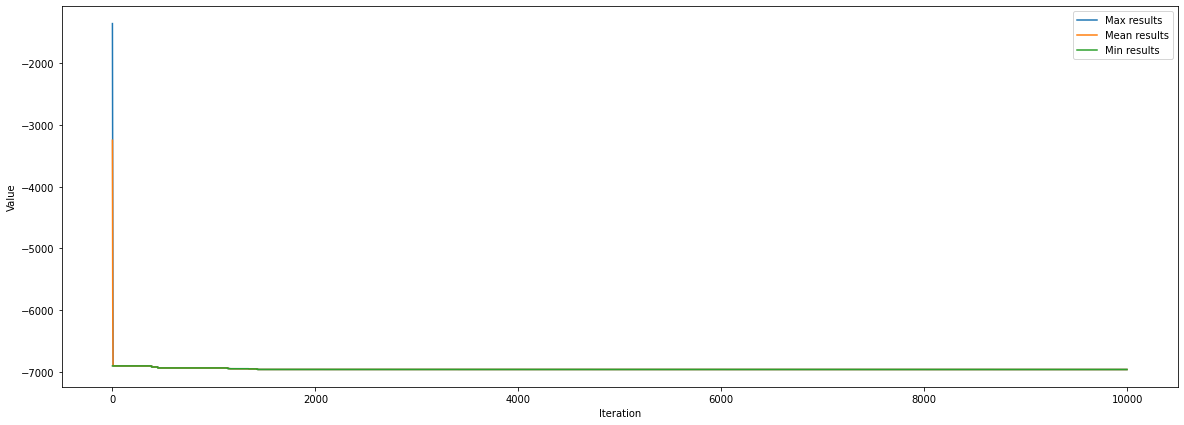

[14.09503558  0.84303391]


In [83]:
res=constrained_ES_mi_lambda_for_g6(G6_objective_function, 50, 50, G6_restrictions)
plot_chart(res)
print(res[0])

Mi, lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


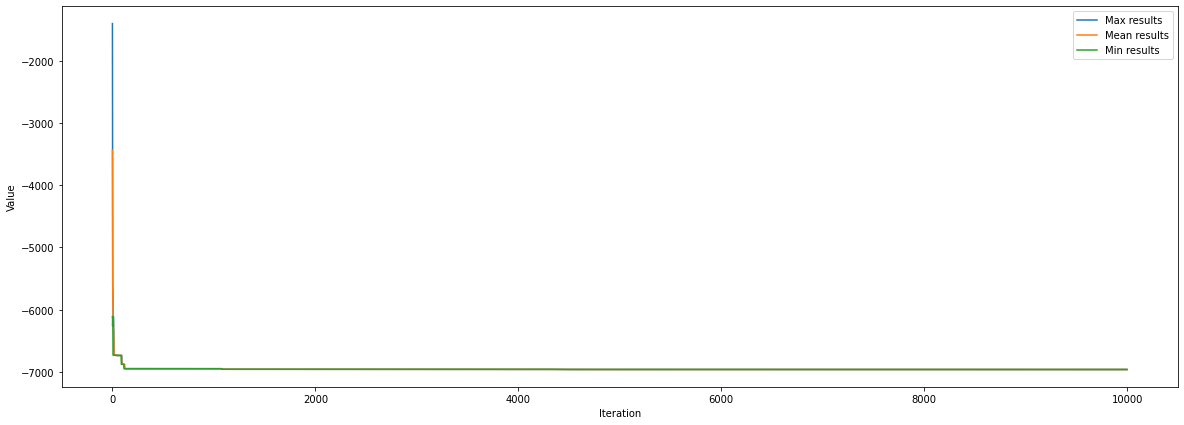

[14.095       0.84296079]


In [22]:
res=constrained_ES_mi_lambda_for_g6(G6_objective_function, 50, 100, G6_restrictions, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G8

In [23]:
def G8_restrictions(individual):
    return individual[0] ** 2 + 1 <= individual[1] and 1 + (individual[1] - 4) ** 2 <= individual[0]
constrained_random_population(2, 10, G8_restrictions, (0, 10), (0, 1))

array([[[1.33828162, 4.39676067],
        [0.5747534 , 0.54397482]],

       [[1.78414924, 4.30409365],
        [0.41321269, 0.62715656]],

       [[1.33426401, 4.44379287],
        [0.42565892, 0.9863116 ]],

       [[1.92020604, 4.75763386],
        [0.65414233, 0.23061058]],

       [[1.38591642, 3.65764417],
        [0.13896659, 0.37430622]],

       [[1.54255405, 4.15821221],
        [0.15684649, 0.85089008]],

       [[1.97822385, 4.95695459],
        [0.95017057, 0.65553788]],

       [[1.42624015, 4.2957378 ],
        [0.18605705, 0.36062891]],

       [[1.23057262, 3.72493894],
        [0.25282812, 0.19666629]],

       [[1.22244078, 4.17234688],
        [0.78542716, 0.08655556]]])

In [24]:
def G8_objective_function(individual):
    return ((np.sin(2 * np.pi * individual[0]) ** 3) * np.sin(2 * np.pi * individual[1])) / (individual[0] ** 4 + (individual[0] ** 3) * individual[1])
G8_objective_function([1.2279713, 4.2453733])

0.09582504141801164

Mi + lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


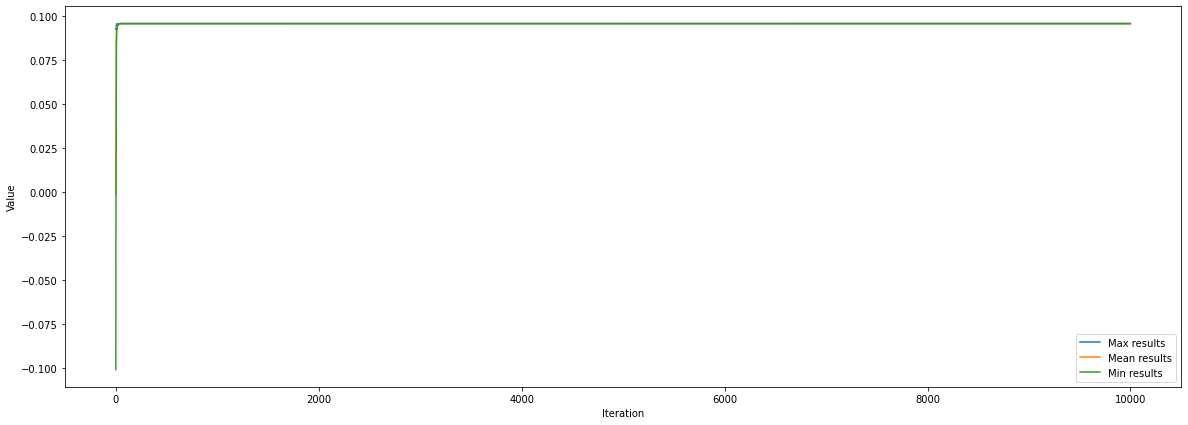

[1.22772068 4.24536043]


In [69]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 100, G8_restrictions, (0, 10), looking_for_max=True)
plot_chart(res)
print(res[0])

Mi, lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


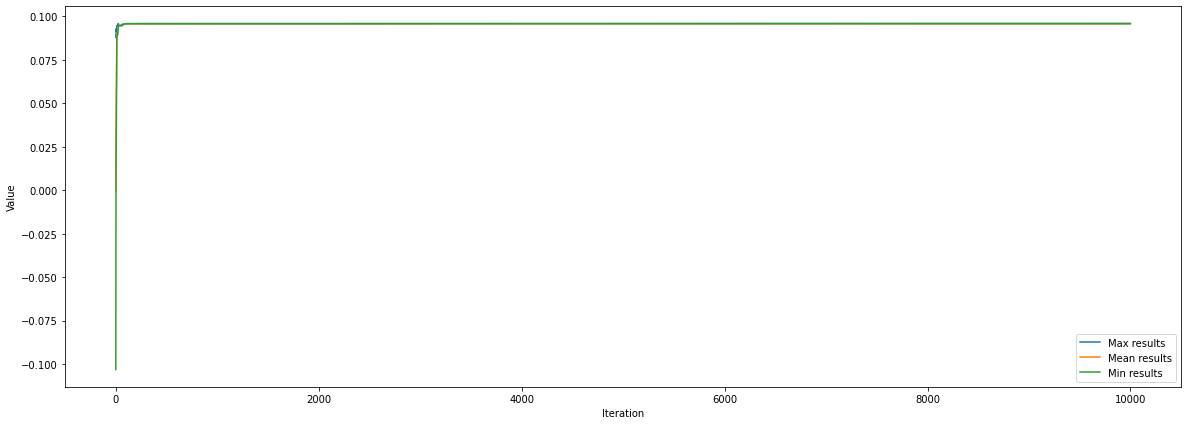

[1.2277535  4.24615594]


In [25]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 200, G8_restrictions, (0, 10), looking_for_max=True, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G11

In [26]:
def G11_objective_function(individual):
    return (individual[0] ** 2) + (individual[1] - 1) ** 2

In [27]:
def constrained_random_population_for_g11(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(-1, 1, 1)[0]
        res[num_of_child, 0, :]=np.array([candidate, candidate ** 2])
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res

In [28]:
def constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = P_children[i, 0, :]
        epsilons_for_first_chromosome = (np.random.normal(0, 1, 1) * P_children[i, 1, 0])
        P_children[i, 0, 0] = P_children[i, 0, 0] + epsilons_for_first_chromosome
        P_children[i, 0, 1] =  P_children[i, 0, 0] ** 2
    return P_children

In [29]:
def constrained_ES_mi_lambda_for_g11(objective_function, mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g11(mi_param, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 2000 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


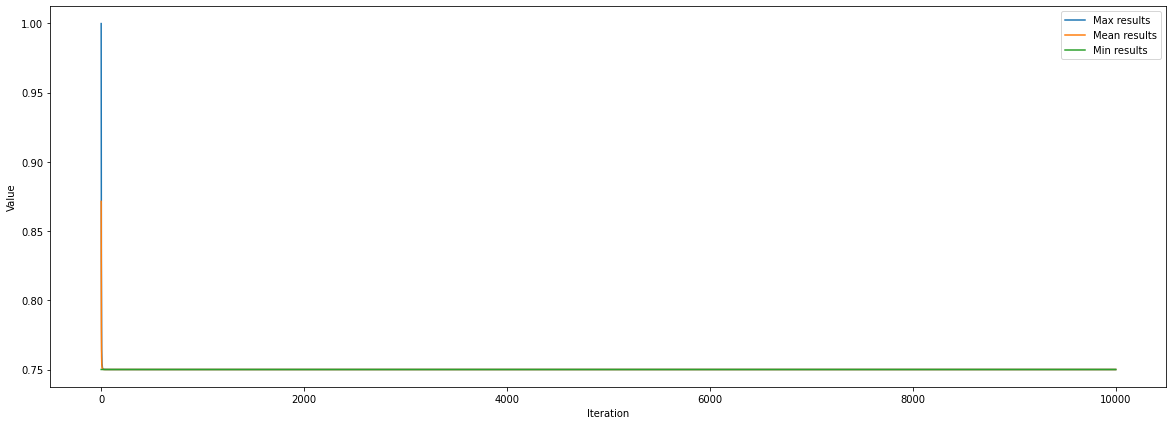

[-0.70710677  0.49999999]


In [42]:
res=constrained_ES_mi_lambda_for_g11(G11_objective_function, 100, 100)
plot_chart(res)
print(res[0])

Mi, lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


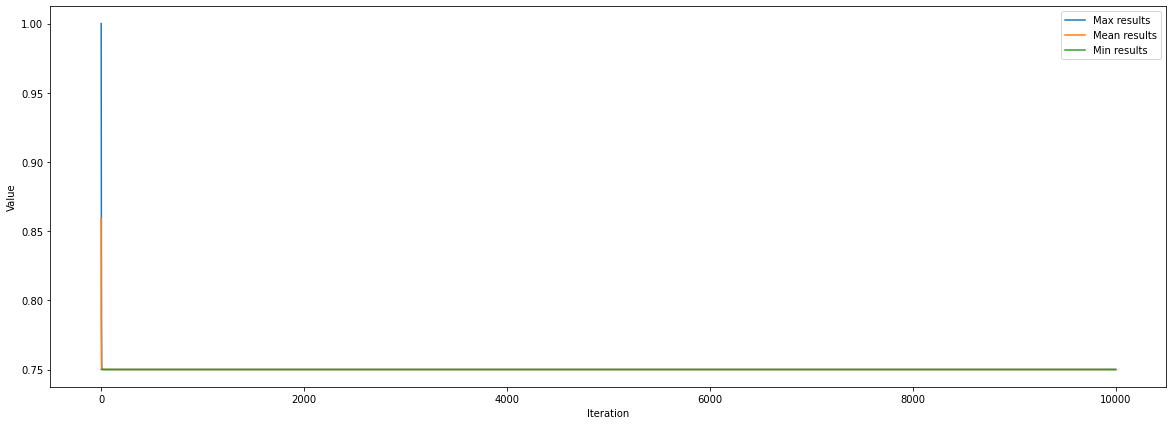

[0.70710678 0.5       ]


In [30]:
res=constrained_ES_mi_lambda_for_g11(G11_objective_function, 100, 200, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G12

In [31]:
def G12_restrictions(individual):
    for i in ([np.floor(individual[0]), np.ceil(individual[0])]):
        for j in ([np.floor(individual[1]), np.ceil(individual[1])]):
            for k in ([np.floor(individual[2]), np.ceil(individual[2])]):
                if i > 0 and i < 10 and j > 0 and j < 10 and k > 0 and k < 10 and (individual[0] - i) ** 2 + (individual[1] - j) ** 2 + (individual[2] - k) ** 2 <= 0.0625:
                    return True
    return False
constrained_random_population(3, 10, G12_restrictions, (0, 10), (0, 1))

array([[[8.12625094e+00, 6.86301952e+00, 7.04274195e+00],
        [4.28753515e-01, 5.06362957e-01, 9.09074294e-01]],

       [[7.78350271e+00, 8.00158416e+00, 6.10969828e+00],
        [8.92519769e-01, 9.85955300e-01, 9.00138283e-01]],

       [[9.97991802e-01, 7.09013028e+00, 5.16595983e+00],
        [3.66536619e-01, 7.00043601e-03, 5.94960439e-01]],

       [[8.02049166e+00, 2.88831920e+00, 1.96877226e+00],
        [5.00365117e-01, 5.61982620e-01, 6.13934130e-01]],

       [[5.96478297e+00, 6.80180413e+00, 9.76346087e-01],
        [2.13467938e-01, 6.72457060e-02, 6.93253813e-01]],

       [[9.09653410e+00, 4.89192802e+00, 5.10413940e+00],
        [6.41747038e-01, 2.70309181e-01, 8.69593224e-01]],

       [[2.84101455e+00, 8.91510907e+00, 2.94001681e+00],
        [7.76530851e-01, 6.87674743e-01, 7.62826917e-01]],

       [[4.12856226e+00, 3.06600978e+00, 4.98847863e+00],
        [5.00794731e-01, 3.29355980e-01, 1.36059395e-01]],

       [[2.14075944e+00, 2.98519789e+00, 3.19433490e+00]

In [32]:
def G12_objective_function(individual):
    return 0.01 * ((individual[0] - 5) ** 2 + (individual[1] - 5) ** 2 + (individual[2] - 5) ** 2) - 1
G12_objective_function(np.array([10.0, 10.0, 10.0]))

-0.25

Mi + lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


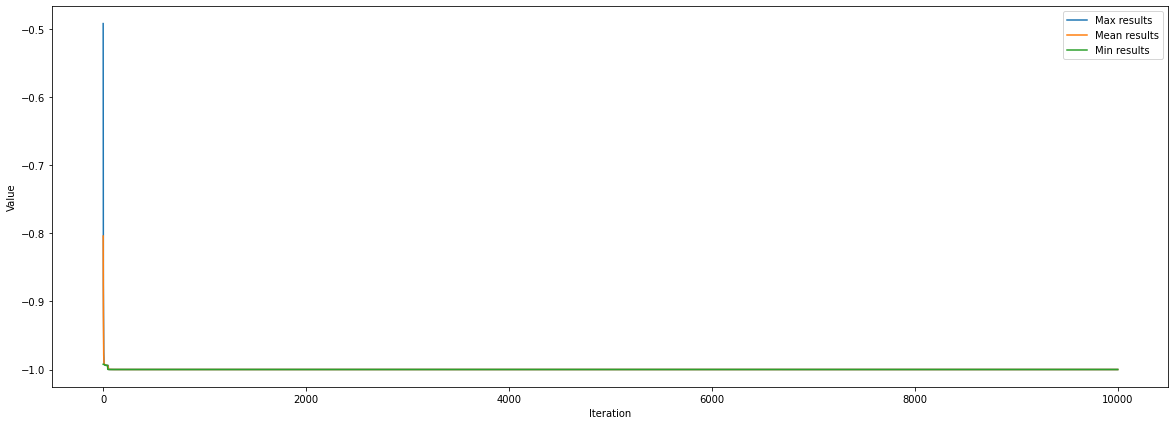

[5.00072752 5.00904037 5.00515044]


In [50]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 100, G12_restrictions, (0, 10))
plot_chart(res)
print(res[0])

Mi, lambda

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


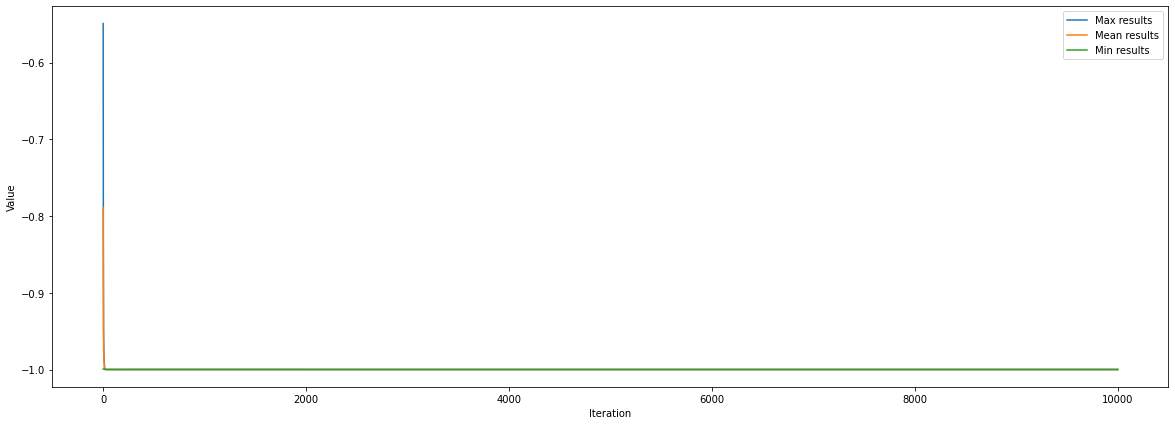

[4.99745112 4.99929088 4.99027697]


In [33]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 200, G12_restrictions, (0, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])